In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..") # Adds the module to path

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/fix-mie/examples/paper-examples/4-multi-molecule-tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Example 4. Multi-particle tracking

## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

from deeptrack.extras import datasets
datasets.load('QuantumDots')

IMAGE_SIZE = 128

Dataset already downloaded.


## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 128 by 128 pixel images, containing multiple particles each. The particles are simulated as point scatterers. Their position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE,
    z=lambda: np.random.randn() * 5,
    intensity=lambda: 1 + np.random.rand() * 9,
    position_unit="pixel",
)

number_of_particles = lambda: np.random.randint(10, 20)

particles = particle ^ number_of_particles

The particles are imaged using a fluorescence microscope with NA between 0.6 and 0.8, illuminating laser wavelength of 500 nm, and a magnification of 10.

In [4]:
optics = dt.Fluorescence(
    NA=lambda: 0.6 + np.random.rand() * 0.2,
    wavelength=500e-9,
    resolution=1e-6,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

The noise is simulated as poisson noise with a signal to noise ratio between 4 and 7. The image is finally normalized by rescaling it to be contained between two random numbers within (0, 1).

In [5]:

normalization = dt.NormalizeMinMax(
    min=lambda: np.random.rand() * 0.4,
    max=lambda min: min + 0.1 + np.random.rand() * 0.5,
)

noise = dt.Poisson(
    snr=lambda: 4 + np.random.rand() * 3,
    background=normalization.min
)


We now define how these objects combine

In [6]:
imaged_particle = optics(particles)

dataset = imaged_particle >> normalization >> noise

### 2.2 Defining the training label

Each particle is represented by a disk with a radius of 3 pixels.

In [7]:
CIRCLE_RADIUS = 3

X, Y = np.mgrid[:2*CIRCLE_RADIUS, :2*CIRCLE_RADIUS]

circle = (X - CIRCLE_RADIUS + 0.5)**2 + (Y - CIRCLE_RADIUS + 0.5)**2 < CIRCLE_RADIUS**2
circle = np.expand_dims(circle, axis=-1)

get_masks = dt.SampleToMasks(
    lambda: lambda image: circle,
    output_region=optics.output_region,
    merge_method="or"
)

def get_label(image_of_particles):
    return get_masks.update().resolve(image_of_particles)

### 2.3 Visualizing the dataset

We resolve and show 16 images.

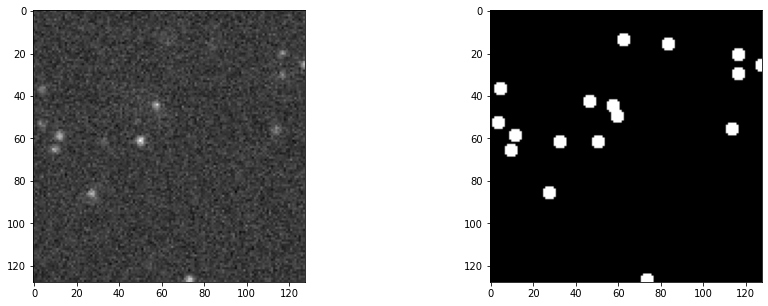

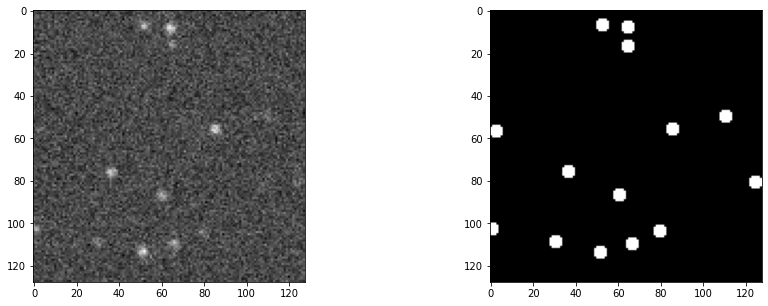

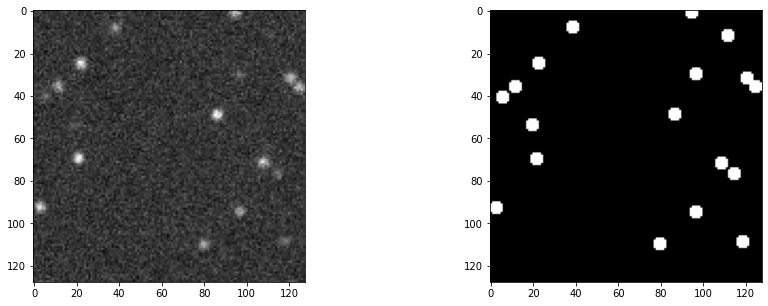

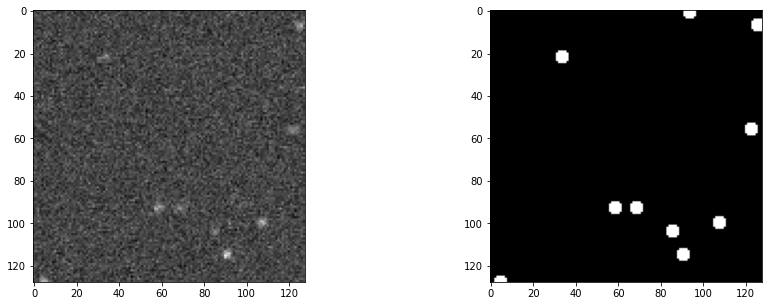

In [8]:
NUMBER_OF_IMAGES = 4

for _ in range(NUMBER_OF_IMAGES):
    plt.figure(figsize=(15, 5))
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    particle_label = get_label(image_of_particle)
    plt.subplot(1, 2, 1)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(particle_label[..., 0] * 1.0, cmap="gray")
    plt.show()
    

## 3. Defining the network

The network used is a U-Net, with a the pixel error as loss.

In [9]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

loss = dt.losses.flatten(
    dt.losses.weighted_crossentropy((10, 1))
)
metric = dt.losses.flatten(
    dt.losses.weighted_crossentropy((1, 1))
)
model = dt.models.UNet(
    (None, None, 1), 
    conv_layers_dimensions=[16, 32, 64],
    base_conv_layers_dimensions=[128, 128], 
    loss=loss,
    metrics=[metric],
    output_activation="sigmoid"
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           activation[0][0]                 
______________________________________________________________________________________________

## 4. Training the network

The network is trained similarly to example 2.

In [10]:
TRAIN_MODEL = True

validation_set_size = 100

validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset & (dataset >> get_label),
        batch_size=16,
        min_data_size=1e3,
        max_data_size=1e4,
    )

    with generator:

        # Train 5 epochs with weighted loss
        h = model.fit(generator,
                      epochs=10,
                         validation_data=(
                              np.array(validation_set),
                              np.array(validation_labels)
                          ))

        model.compile(loss=metric, optimizer="adam")

        # Train 30 epochs with unweighted loss
        h2 = model.fit(generator,
                      epochs=60,
                      validation_data=(
                          np.array(validation_set),
                          np.array(validation_labels)
                      ))
        
else:
    model_path = datasets.load_model("QuantumDots")
    model.load_weights(model_path)

Generating 1004 / 1000.0 samples before starting training
Epoch 1/10
62/62 [==============================] - 9s 74ms/step - loss: 0.0681 - nd_unet_crossentropy: 0.2400 - val_loss: 0.0376 - val_nd_unet_crossentropy: 0.0401
Epoch 2/10
62/62 [==============================] - 1s 15ms/step - loss: 0.0303 - nd_unet_crossentropy: 0.0542 - val_loss: 0.0145 - val_nd_unet_crossentropy: 0.0359
Epoch 3/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0145 - nd_unet_crossentropy: 0.0381 - val_loss: 0.0105 - val_nd_unet_crossentropy: 0.0233
Epoch 4/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0106 - nd_unet_crossentropy: 0.0274 - val_loss: 0.0096 - val_nd_unet_crossentropy: 0.0278
Epoch 5/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0095 - nd_unet_crossentropy: 0.0249 - val_loss: 0.0084 - val_nd_unet_crossentropy: 0.0194
Epoch 6/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0088 - nd_unet_crossentropy: 0.0226 - val_

## 5. Evaluating the network

### 5.1 Prediction visualization

We show a few images, with the ground truth and network prediction.

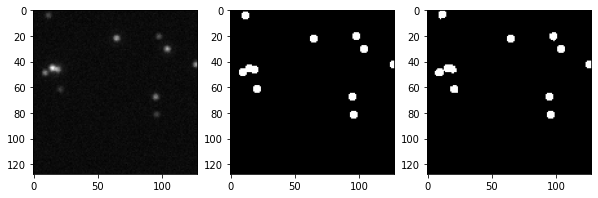

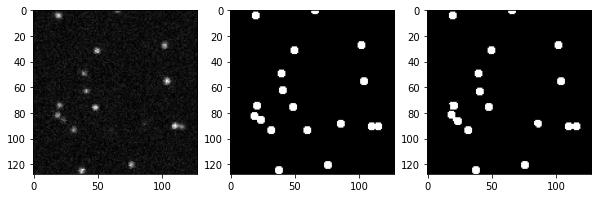

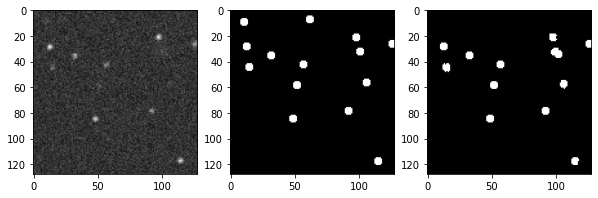

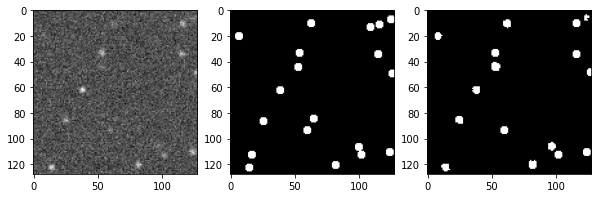

In [11]:
NUMBER_OF_IMAGES = 4


for _ in range(NUMBER_OF_IMAGES):
    plt.figure(figsize=(10, 10))
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    
    predicted_mask = model.predict(np.array([image_of_particle]))
    particle_label = get_label(image_of_particle)
    plt.subplot(1, 3, 1)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(particle_label[..., 0] * 1.0, cmap="gray")
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[0, ..., 0] > 0.5, cmap="gray")
    plt.show()

### 5.2 Prediction vs actual

We play a video of quantum dots, as tracked by the trained network.

In [12]:
import skimage.io

IMAGES_TO_PLAY=64

images = skimage.io.imread("./datasets/QuantumDots/Qdots.tif")
images = np.expand_dims(images[:IMAGES_TO_PLAY], axis=-1)
images = dt.NormalizeMinMax(0, 1).resolve(list(images))

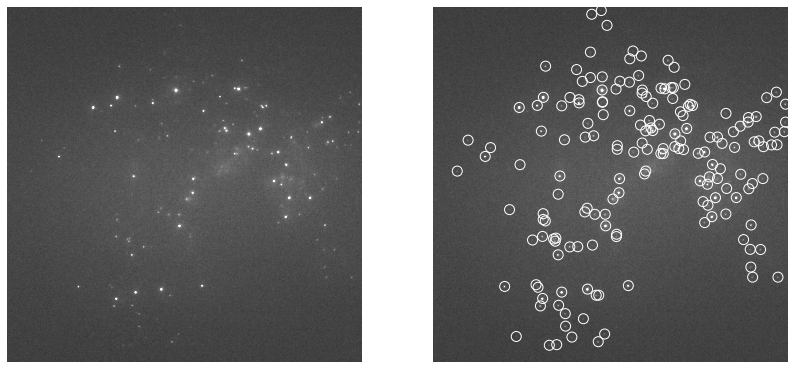

In [13]:
import IPython
to_predict_on = [images[i] / 3 + images[i + 1] / 3 + images[i-1] / 3 for i in range(1, len(images) - 1)]
predictions = model.predict(np.array(to_predict_on), batch_size=1)

for prediction, image in zip(predictions, images[1:-1]):
    plt.figure(figsize=(14, 7))
    mask = prediction[:,:,0] > 0.99
    
    cs = np.array(skimage.measure.regionprops(skimage.measure.label(mask)))
    
    cs = np.array([c["Centroid"] for c in cs])
    
    plt.subplot(1,2,1)
    plt.imshow(image[..., 0], vmax=0.1, cmap="gray")  
    plt.axis("off")
    plt.axis([0, 1200, 0, 1200])
    
    plt.subplot(1,2,2)
    plt.imshow(image[..., 0], vmax=0.1, cmap="gray")
    plt.scatter(cs[:, 1], cs[:, 0], 100, facecolors="none", edgecolors="w")
    plt.axis("off")
    plt.axis([0, 1200, 0, 1200])
    
    IPython.display.clear_output(wait=True)
    plt.show()
    plt.pause(0.1)
